In [1]:
import sys
sys.path.insert(1, "../")

import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset, default_mappings

from ghost_unfairness.utils import *

In [24]:
protected = ["sex"]
privileged_classes = [['Male']]
metadata = default_mappings.copy()
metadata['protected_attribute_maps'] = [{1.0: 'Male', 0.0: 'Female'}]

alpha = 0.5
beta = 1

kwargs = {'protected_attribute_names': protected,
          'privileged_classes': [['Male']],
          'metadata':metadata,
          'beta': beta,
          'alpha': alpha
         }

privileged_groups = [{key:1 for key in protected}]
unprivileged_groups = [{key:0 for key in protected}]

random_state = 47

In [25]:
model_type = LogisticRegression

if model_type == DecisionTreeClassifier:
    params = {'criterion':'entropy',
          'random_state': 47} 
elif model_type == LogisticRegression:
    params = {'class_weight': 'balanced',
              'solver': 'liblinear'}
elif model_type == GaussianNB:
    params = {}

In [26]:
train_fd = FairDataset(10000, 2, **kwargs,
                      random_state=random_state)
test_fd = FairDataset(5000, 2, **kwargs,
                     random_state=53)

In [27]:
test_fd

               instance weights   features                                 \
                                                      protected attribute   
                                         0          1                 sex   
instance names                                                              
0                           1.0   3.411730   5.333523                 1.0   
1                           1.0  -1.145280   1.734626                 1.0   
2                           1.0   4.994253   7.789108                 1.0   
3                           1.0   1.917533   4.505411                 1.0   
4                           1.0  -1.300704   2.389119                 1.0   
...                         ...        ...        ...                 ...   
9995                        1.0   2.170465  12.626533                 0.0   
9996                        1.0  -1.263141  15.023160                 0.0   
9997                        1.0  17.615968   4.310421                 0.0   

In [28]:
def train_model(model_type, data, params):
    
    x, y = data.get_xy(keep_protected=False)
    
    model = model_type()
    # params[variant] = val
    model.set_params(**params)

    model = model.fit(x, y)

    return model

In [29]:
train_fd_p = train_fd.get_privileged_group()
train_fd_u = train_fd.get_unprivileged_group()

pmod = train_model(model_type,
                   train_fd_p, params)

umod = train_model(model_type,
                   train_fd_u, params)

In [30]:
# df, _ = test_fd.convert_to_dataframe()
# print(df[(df['sex']==1) & (df['label']==0)].describe())
# print(df[(df['sex']==1) & (df['label']==1)].describe())
# print(df[(df['sex']==0) & (df['label']==0)].describe())
# print(df[(df['sex']==0) & (df['label']==1)].describe())

In [31]:
# df, _ = train_fd_p.convert_to_dataframe()
# print(df[df['label']==0].describe())
# print(df[df['label']==1].describe())

In [32]:
# df, _ = train_fd_u.convert_to_dataframe()
# print(df[df['label']==0].describe())
# print(df[df['label']==1].describe())

In [33]:
get_classifier_metrics(pmod, test_fd,
                       unprivileged_groups,
                       privileged_groups,
                       verbose=True)

Mean Difference: 0.055400000000000005
Disparate Impact: 0.1105788423153693
Accuracy: 0.9511


[-0.055400000000000005, 0.8894211576846307, 0.9511, 0.995, 0.9072]

In [34]:
print(get_model_properties(pmod))

[[-1.10184103 -1.12328913]]


In [35]:
get_classifier_metrics(umod, test_fd,
                       unprivileged_groups,
                       privileged_groups,
                       verbose=True)

Mean Difference: 0.027599999999999958
Disparate Impact: 0.05155024280911458
Accuracy: 0.9448


[-0.027599999999999958, 0.9484497571908854, 0.9448, 0.9642, 0.9254]

In [36]:
print(get_model_properties(umod))

[[-0.39604845 -0.39754765]]


In [37]:
mod = train_model(model_type,
                  train_fd, params)
get_classifier_metrics(mod, test_fd,
                       unprivileged_groups,
                       privileged_groups,
                       verbose=True)

Mean Difference: 0.035800000000000054
Disparate Impact: 0.07011359185272237
Accuracy: 0.9527


[-0.035800000000000054, 0.9298864081472776, 0.9527, 0.9882, 0.9172]

In [38]:
print(get_model_properties(mod))

[[-0.57190127 -0.56747824]]


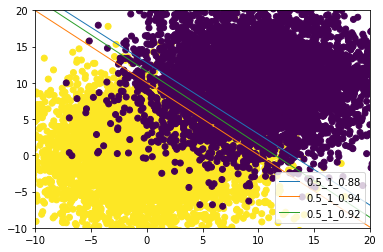

In [44]:
plot_lr_boundary(pmod, plt, alpha, beta, 0.88)
plot_lr_boundary(umod, plt, alpha, beta, 0.94)
plot_lr_boundary(mod, plt, alpha, beta, 0.92)
test_fd_x, test_fd_y = train_fd.get_xy(keep_protected=False)
plt.scatter(test_fd_x['0'], test_fd_x['1'], c=test_fd_y, label=None)
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.legend()

In [19]:
def get_model_performances(model_type, train, test, params):
    train_p = train.get_privileged_group()
    train_u = train.get_unprivileged_group()
    
    mod = train_model(model_type, train, params)
    
    pmod = train_model(model_type, train_p, params)

    umod = train_model(model_type, train_u, params)
    
    
    print('Mod')
    _, mod_di, mod_ac, _, _ = get_classifier_metrics(mod, test,
                                               privileged_groups,
                                               unprivileged_groups,
                                               verbose=True)
    print('P Mod')
    _, pmod_di, pmod_ac, _, _ = get_classifier_metrics(pmod, test,
                                                 privileged_groups,
                                                 unprivileged_groups,
                                                 verbose=True)

    print('U Mod')    
    _, umod_di, umod_ac, _, _ = get_classifier_metrics(umod, test,
                                                 privileged_groups,
                                                 unprivileged_groups,
                                                 verbose=True)

In [20]:
params = {'criterion':'entropy',
          'random_state': 47}
    
variant = 'max_depth'
max_depths = [3, 5, 10, 15, 20, 25]
for md in max_depths:
    params[variant] = md
    get_model_performances(DecisionTreeClassifier, train_fd, 
                           test_fd, params)

Mod
Mean Difference: 0.004799999999999999
Disparate Impact: 0.024365482233502433
Accuracy: 0.9602
P Mod
Mean Difference: 0.01580000000000001
Disparate Impact: 0.08512931034482762
Accuracy: 0.9587
U Mod
Mean Difference: 0.0116
Disparate Impact: 0.05183199285075957
Accuracy: 0.9456
Mod
Mean Difference: 0.021799999999999986
Disparate Impact: 0.12428734321550738
Accuracy: 0.9645
P Mod
Mean Difference: 0.013800000000000007
Disparate Impact: 0.07395498392282973
Accuracy: 0.9585
U Mod
Mean Difference: 0.021999999999999992
Disparate Impact: 0.12249443207126953
Accuracy: 0.963
Mod
Mean Difference: 0.02159999999999998
Disparate Impact: 0.12094064949608052
Accuracy: 0.9622
P Mod
Mean Difference: 0.01580000000000001
Disparate Impact: 0.0849462365591398
Accuracy: 0.9589
U Mod
Mean Difference: 0.02460000000000001
Disparate Impact: 0.132400430570506
Accuracy: 0.9479
Mod
Mean Difference: 0.020800000000000013
Disparate Impact: 0.11378555798687096
Accuracy: 0.9546
P Mod
Mean Difference: 0.01539999999999